### This notebook aims to predict whether a product is a failure or not based on some measurement,attribute and loading variables. The dataset was used in Kaggle Tabular _Playgorund Series-August22_ . The dataset can be found [here](https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/data?select=train.csv)

# Importing Libraries 

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore,Back,Style 
import scipy.stats
import warnings
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, roc_curve

from lightgbm import LGBMClassifier, early_stopping 

np.set_printoptions(linewidth=150)


# Loading the Dataset

In [3]:
train = pd.read_csv('train.csv',index_col='id')
test = pd.read_csv('test.csv',index_col='id')
display(train)
display(test)

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,E,158.95,material_7,material_6,6,9,6,16,4,16.301,...,NaN,12.177,17.942,10.112,15.795,18.572,16.144,NaN,729.131,0
26566,E,146.02,material_7,material_6,6,9,10,12,8,17.543,...,11.242,14.179,20.564,10.234,14.450,14.322,13.146,16.471,853.924,0
26567,E,115.62,material_7,material_6,6,9,1,10,1,15.670,...,11.407,16.437,17.476,8.668,15.069,16.599,15.590,14.065,750.364,0


,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,
26570,F,119.57,material_5,material_6,6,4,6,9,6,19.305,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
26571,F,113.51,material_5,material_6,6,4,11,8,0,17.883,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
26572,F,112.16,material_5,material_6,6,4,8,12,4,18.475,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
26573,F,112.72,material_5,material_6,6,4,8,11,10,16.518,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
26574,F,208.00,material_5,material_6,6,4,14,16,8,17.808,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47340,I,144.74,material_7,material_5,9,5,0,4,9,18.465,...,18.573,11.691,NaN,19.771,11.562,17.246,15.131,15.209,NaN,696.466
47341,I,74.53,material_7,material_5,9,5,4,8,7,18.900,...,17.917,10.980,16.027,15.694,13.564,15.494,15.296,13.812,16.501,613.249
47342,I,67.73,material_7,material_5,9,5,10,11,2,18.656,...,19.630,10.436,16.137,20.612,11.134,16.519,15.525,14.175,17.728,783.349


In [4]:
both = pd.concat([train[test.columns],test])

## Target Column

In [5]:
print(train['failure'].value_counts()/len(train))

0    0.787392
1    0.212608
Name: failure, dtype: float64


We can see that the target column is a bit unbalanced as 79 products are good and 21 are not. To in this case _Stratified Cross Validation_ will be used.

## Float columns

The dataset consists of 16 float columns. All the columns have missing values (up to 10%)

**Insight:** We'll need to impute the missing values (unless we use a classifier which deals with missing values automatically). The simplest solution is filling the missing values with the columns's mean, but this simple solution won't be effective. A more dophisticatec solution might use the imputers from [sklearn.impute](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute) or even some customization imputation scheme

In [6]:
float_cols = [f for f in train.columns if train[f].dtype == float]
# float_col = [f for f in train.select_dtypes('float')]  #provides similar result 

In [7]:
pd.concat([train[float_cols].isnull().sum().rename('missing values in train'), test[float_cols].isnull().sum().rename('missing values in test')], axis=1)

,missing values in train,missing values in test
loading,250,223
measurement_3,381,329
measurement_4,538,409
measurement_5,676,508
measurement_6,796,624
measurement_7,937,720
measurement_8,1048,846
measurement_9,1227,904
measurement_10,1300,1067
measurement_11,1468,1136


In [8]:
print(both[float_cols].isna().any(axis=1))

id
0         True
1        False
2         True
3        False
4        False
         ...  
47340     True
47341     True
47342     True
47343    False
47344    False
Length: 47345, dtype: bool


In [9]:
print(f"{both[float_cols].isna().any(axis=1).sum()/len(both):.0%}")

54%


**Insight:** As there's over 50% of samples with missing values, the aim will be to impute effectively. 


The histogram of the float features are given below. 

Text(0.5, 1.04, 'Train and test distributions of the continuous features')

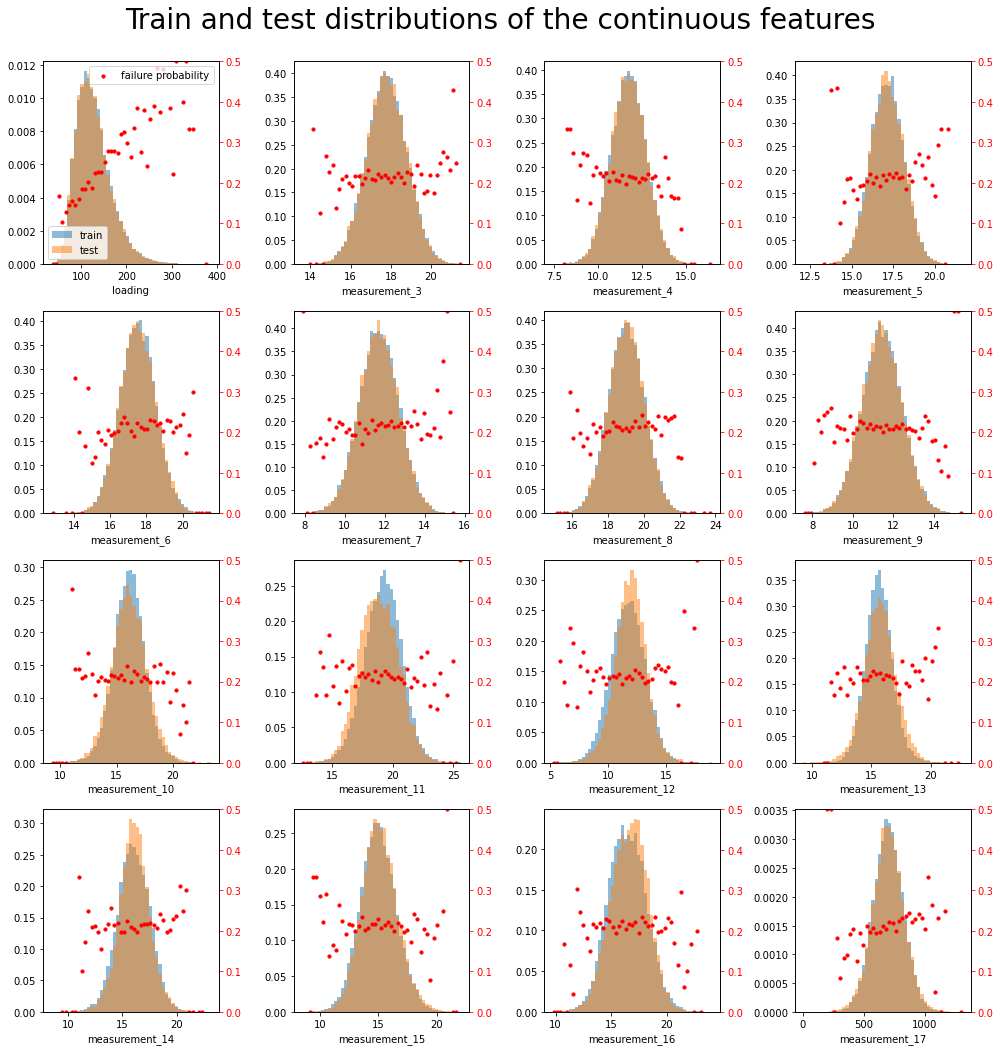

In [10]:
_, axs = plt.subplots(4,4, figsize=(14,14))
for f, ax in zip(float_cols, axs.ravel()):
    mi = min(train[f].min(), test[f].min())
    ma = max(train[f].max(), test[f].max())
    bins = np.linspace(mi,ma,50)
    ax.hist(train[f], bins=bins, alpha = 0.5, density=True, label='train')
    ax.hist(test[f], bins=bins, alpha = 0.5, density=True, label='test')
    ax.set_xlabel(f)
    if ax == axs[0,0]: ax.legend(loc='lower left')

    ax2 = ax.twinx()
    total, _ = np.histogram(train[f], bins=bins)
    failures,_ = np.histogram(train[f][train.failure==1], bins=bins)
    with warnings.catch_warnings(): # ignore dividew by zero for empty bins
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        ax2.scatter((bins[1:] + bins[:-1]) / 2, failures/total,
                    color='r', s=10, label='failure probability')

    ax2.set_ylim(0, 0.5)
    ax2.tick_params(axis='y', colors='r')
    if ax == axs[0,0]: ax2.legend(loc='upper right')
plt.tight_layout(w_pad =1)
plt.suptitle("Train and test distributions of the continuous features", fontsize = 28, y=1.04)

From the histograms we can see that the histogram of *loading* is a bit skewed on the left. This means the distribution seems like a log normal distribution. Where as all the other distributions are normal distributions. In the first 8 distributions the train and test distributions are aligned. Where as the other distributions differ slightly.

The magenta dots present the probability of failures. The first diagram shows a clear positive correlation between *loadings* and failure porbability. Same goes for *measurement_17*. Where as it's unclear what is the exact relation between the features and target from the other diagrams. 

**Insight:** 
- Maybe we can apply a log-transformation to the loading to make the distribution more symmetric.
- As the measurements are uncorrelated to the failure probability, they are useless for a linear classifier. We need more complex classifiers which can deal with feature interactions (decision trees, neural networks, ...) - or good feature engineering.

Did it occur to you that a missing measurement might be an early indicator of product failure? Maybe the cause of a product failure triggers the failure of a measurement device. How can we test this idea? Obviously we have to calculate the conditional product failure rate given the measurement is missing E[product fails | measurement is missing] and compare it to the unconditional product failure rate, which is 0.212608.

Of course, the deviations will be small and we should test them for significance against a null hypothesis which says that the failure count is binomially distributed with p = 0.212608. For simplicity, we can approximate the binomial distribution by a normal distribution, calculate the z-score and the p-value:

feature           fail   miss   failure rate       z    p-value
loading         :   44 /  250 = 0.176          -1.41      0.157
measurement_3   :   61 /  381 = 0.160          -2.50      0.012
measurement_4   :  128 /  538 = 0.238           1.43      0.151
measurement_5   :  172 /  676 = 0.254           2.66      0.008
measurement_6   :  171 /  796 = 0.215           0.15      0.879
measurement_7   :  197 /  937 = 0.210          -0.18      0.860
measurement_8   :  218 / 1048 = 0.208          -0.36      0.716
measurement_9   :  283 / 1227 = 0.231           1.54      0.123
measurement_10  :  277 / 1300 = 0.213           0.04      0.967
measurement_11  :  311 / 1468 = 0.212          -0.07      0.944
measurement_12  :  356 / 1601 = 0.222           0.95      0.340
measurement_13  :  373 / 1774 = 0.210          -0.24      0.809
measurement_14  :  413 / 1874 = 0.220           0.82      0.411
measurement_15  :  430 / 2009 = 0.214           0.16      0.876
measurement_16  :  436 / 2110 = 0.207   

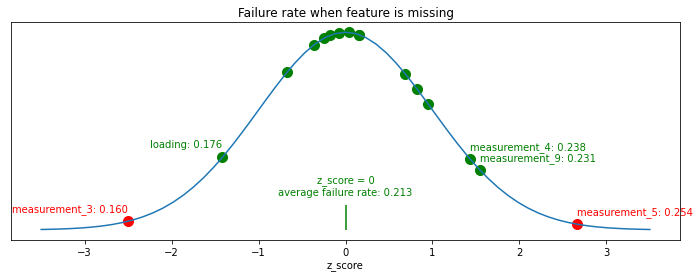

In [11]:
# Start by plotting the bell curve
plt.figure(figsize=(12, 4))
z_ticks = np.linspace(-3.5, 3.5, 61)
pdf = scipy.stats.norm.pdf(z_ticks)
plt.plot(z_ticks, pdf)

# Calculate the conditional failure rate for every missing feature
# Print the values and plot them
print('feature           fail   miss   failure rate       z    p-value')
for f in train.columns:
    if train[f].isna().sum() > 0:
        total = train[f].isna().sum() 
        fail = train[train[f].isna()].failure.sum()
        z = (fail / total - 0.212608) / (np.sqrt(0.212608 * (1-0.212608)) / np.sqrt(total)) # determining  z_score
        plt.scatter([z], [scipy.stats.norm.pdf(z)], c='r' if abs(z) > 2 else 'g', s=100)
        print(f"{f:15} : {fail:4} / {total:4} = {fail/total:.3f}          {z:5.2f}      {2*scipy.stats.norm.cdf(-abs(z)):.3f}")
        if abs(z) > 1: plt.annotate(f"{f}: {fail / total:.3f}",
                                    (z, scipy.stats.norm.pdf(z)),
                                    xytext=(0,10), 
                                    textcoords='offset points', ha='left' if z > 0 else 'right',
                                    color='r' if abs(z) > 2 else 'g')
            
# Annotage the center (z=0)
plt.vlines([0], 0, 0.05, color='g')
plt.annotate(f"z_score = 0\naverage failure rate: {0.212608:.3f}",
                                    (0, 0.05),
                                    xytext=(0,10), 
                                    textcoords='offset points', ha='center',
                                    color='g')
plt.title('Failure rate when feature is missing')
plt.yticks([])
plt.xlabel('z_score')
plt.show()

## Integer Columns

In [12]:
int_cols = [i for i in train.columns if train[i].dtype== 'int64' and i != 'failure']
pd.concat([train[int_cols].isna().sum().rename('missing values for train'),test[int_cols].isna().sum().rename('missing values for test')],axis=1)

,missing values for train,missing values for test
attribute_2,0,0
attribute_3,0,0
measurement_0,0,0
measurement_1,0,0
measurement_2,0,0


In [13]:
train.failure.groupby(train['measurement_0']).agg(['mean', 'count'])

,mean,count
measurement_0,,
0,0.184015,538
1,0.216521,799
2,0.219920,1255
3,0.198139,1827
4,0.213596,2280
5,0.212379,2585
6,0.218040,2816
7,0.215520,2719
8,0.207163,2457


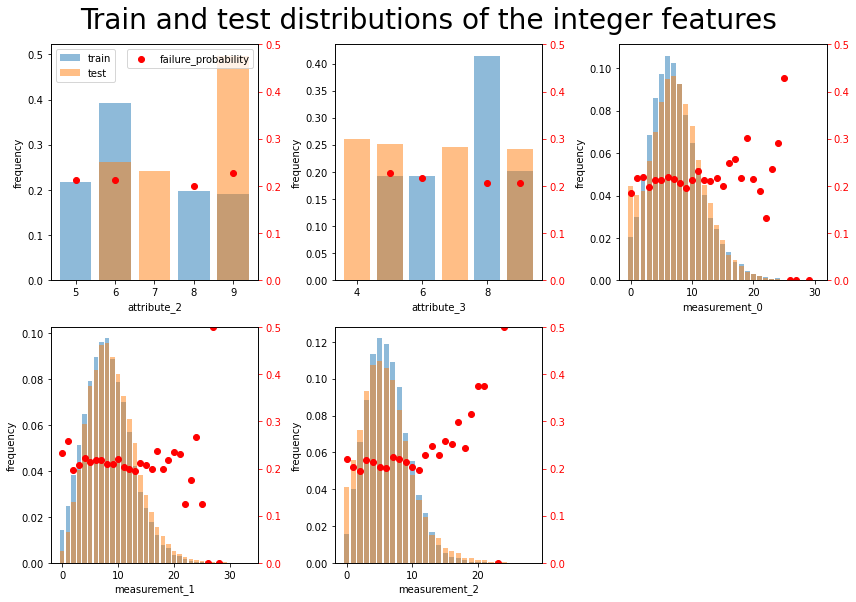

In [14]:
_,axs = plt.subplots(2,3,figsize=(12,8))
for i,ax in zip(int_cols,axs.ravel()):
    temp1 = train.failure.groupby(train[i]).agg(['mean', 'count'])
    ax.bar(temp1.index, temp1['count']/len(train), alpha=0.5,label='train')
    temp2 = test[i].value_counts()
    ax.bar(temp2.index,temp2/len(test),alpha=0.5,label='test')
    ax.set_xlabel(i)
    ax.set_ylabel('frequency')

    ax2 = ax.twinx()
    ax2.scatter(temp1.index,temp1['mean'],
                color = 'r', label='failure_probability')
    ax2.set_ylim(0,0.5)
    ax2.tick_params(axis='y',colors='r')
    if ax == axs[0,0]: ax2.legend(loc = 'upper right')

axs[0, 0].legend()
axs[1,2].axis('off')
plt.tight_layout(w_pad=1)
plt.suptitle("Train and test distributions of the integer features", fontsize=28, y = 1.04)
del temp1,temp2

_attribute_2_ and _attribute_3_ both have some unique values compares to train and test. For instance value (5),value(8) are in train and value(7) in test for _attribute_2_ . Similarly 6,8 are in train and 4,7 on test for _attribute_3_ . Aside from measurement_2 , none of them show a correlation between target and features. 

**Insights:**

- The two attributes could be categorical features. Perhaps we should one-hot encode them and make sure that our classifier can deal with the values which occur only in test.
- As measurement_2 is correlated to the target only for values above 10, linear classifiers will profit if we clip all values below 10.
- Again, most features are uncorrelated to the failure probability. If a linear classifier wins this competition, it will win only with very good feature engineering.

## String columns

There are 3 string columns and none of them contain missing values. 

In [15]:
str_cols = [s for s in train.select_dtypes('object')]
pd.concat([train[str_cols].isna().sum().rename('missing values for train'),test[str_cols].isna().sum().rename('missing values for test')],axis=1)

,missing values for train,missing values for test
product_code,0,0
attribute_0,0,0
attribute_1,0,0


In [16]:
temp1 = train['product_code'].value_counts(dropna=False, normalize=True)
temp2 = test['product_code'].value_counts(dropna=False, normalize=True)
values = sorted(set(temp1.index).union(temp2.index))
temp1 = temp1.reindex(values)
temp2 = temp2.reindex(values)
display(temp1)
display(temp2)

A    0.191946
B    0.197591
C    0.216974
D    0.192397
E    0.201091
F         NaN
G         NaN
H         NaN
I         NaN
Name: product_code, dtype: float64

A         NaN
B         NaN
C         NaN
D         NaN
E         NaN
F    0.260987
G    0.245824
H    0.241540
I    0.251649
Name: product_code, dtype: float64

In [17]:
temp1 = train.failure.groupby(train['product_code']).agg(['mean', 'count'])
temp1

,mean,count
product_code,,
A,0.227255,5100
B,0.200381,5250
C,0.211622,5765
D,0.217527,5112
E,0.207000,5343


C:\Users\Mahdi\AppData\Local\Temp\ipykernel_8072\4255913207.py:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(range(len(values)), values)


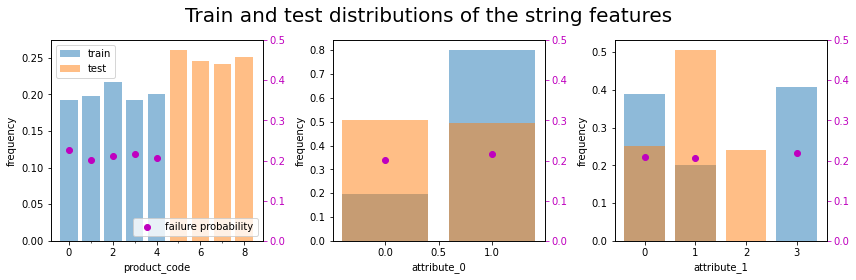

In [18]:
_, axs = plt.subplots(1, 3, figsize=(12, 4))
for f, ax in zip(str_cols, axs.ravel()):
    temp1 = train[f].value_counts(dropna=False, normalize=True)
    temp2 = test[f].value_counts(dropna=False, normalize=True)
    values = sorted(set(temp1.index).union(temp2.index))
    temp1 = temp1.reindex(values)
    temp2 = temp2.reindex(values)
    ax.bar(range(len(values)), temp1, alpha=0.5, label='train')
    ax.bar(range(len(values)), temp2, alpha=0.5, label='test')
    ax.set_xlabel(f)
    ax.set_ylabel('frequency')
    ax.set_xticks(range(len(values)), values)
    
    temp1 = train.failure.groupby(train[f]).agg(['mean', 'count'])
    temp1 = temp1.reindex(values)
    ax2 = ax.twinx()
    ax2.scatter(range(len(values)), temp1['mean'],
                color='m', label='failure probability')
    ax2.tick_params(axis='y', colors='m')
    ax2.set_ylim(0, 0.5)
    if ax == axs[0]: ax2.legend(loc='lower right')

axs[0].legend()
plt.suptitle('Train and test distributions of the string features', fontsize=20, y=0.96)
plt.tight_layout(w_pad=1)
plt.show()
del temp1, temp2   

**Insight:** 
- The product codes of train and test are disjoint: A through E are the training products, F through I are the test products. We want to create a classifier which predicts correct probabilities for previously unseen products. To validate such a classifier, we have to simulate this situation by splitting the data so that the validation set contains other products than the training set. The correct method here is a five-fold cross-validation where every fold uses four products for training and the fifth product for validation (GroupKFold). Forget what I wrote about imbalanced classes and stratified folds above - getting the product codes right is much more important!
- Feature engineering: We can use the product codes for feature engineering by adding aggregate statistics of the measurements, grouped by product code, as new features.
- Attribute_0 and attribute_1 are categorical features which should be one-hot encoded.

## Product Codes and attributes
[@takanashihumbert](https://www.kaggle.com/takanashihumbert) has discovered a [dependency among the attributes](https://www.kaggle.com/code/takanashihumbert/interesting-patterns-found-in-category-features): All four attributes are completely determined by the product code. If we wanted to store the data in a relational database, we'd normalize it by storing the product attributes in a separate table.

In [19]:
both[str_cols + ['attribute_2', 'attribute_3']].drop_duplicates().set_index('product_code')

,attribute_0,attribute_1,attribute_2,attribute_3
product_code,,,,
A,material_7,material_8,9,5
B,material_5,material_5,8,8
C,material_7,material_8,5,8
D,material_7,material_5,6,6
E,material_7,material_6,6,9
F,material_5,material_6,6,4
G,material_5,material_6,9,7
H,material_7,material_7,7,9
I,material_7,material_5,9,5


## Baseline model with crossvalidation

In the following, we'll see how to correctly implement preprocessing and cross-validation for a simple model. You can play around with the hyperparameters - I haven't really optimized them yet.

The code contains a choice of three classifiers: RandomForestClassifier, ExtraTreesClassifier and LogisticRegression. The saved version of the notebook uses LogisticRegression and prints the weights which the classifier optimizes.

When I did this experiment for the first time, I saw that most regression coefficients were near zero, which means that the corresponding features are noise. To verify this thought, I configured the classifier for a l1 penalty. The l1 penalty tries to select as few features as possible for the model.

The pipeline consists of the following steps:

1. Split train and validation (GroupKFold on product_code)
2. One-hot encode attribute_0 and attribute_1
3. Impute the missing values ([KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html))
4. Clip measurement_2
5. Scale the data (StandardScaler)
6. Logistic regression with l1 penalty
7. Evaluate feature importances (regression coefficients)

In [20]:
train['attribute_0'].unique()

array(['material_7', 'material_5'], dtype=object)

In [26]:
train['attribute_1'].unique()

array(['material_8', 'material_5', 'material_6'], dtype=object)

Fold 0: auc = 0.58827
Fold 1: auc = 0.58291
Fold 2: auc = 0.59105
Fold 3: auc = 0.59756
Fold 4: auc = 0.59675
Average auc = 0.59131


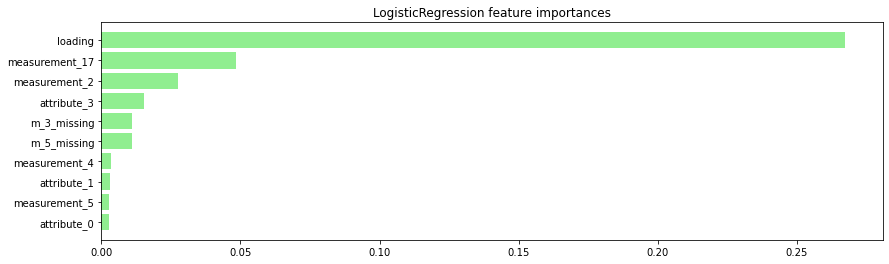

In [29]:
auc_list = []
test_pred_list = []
importance_list = []
kf = GroupKFold(n_splits=5) # must be 5 because of the 5 product codes
for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.failure, train.product_code)):
    X_tr = train.iloc[idx_tr][test.columns]
    X_va = train.iloc[idx_va][test.columns]
    X_te = test.copy()
    y_tr = train.iloc[idx_tr].failure
    y_va = train.iloc[idx_va].failure
    le = LabelEncoder()
    X_tr["attribute_0"] = le.fit_transform(X_tr["attribute_0"])
    X_tr["attribute_1"] = le.fit_transform(X_tr["attribute_1"])
    X_va["attribute_0"] = le.fit_transform(X_va["attribute_0"])
    X_va["attribute_1"] = le.fit_transform(X_va["attribute_1"])
    X_te["attribute_0"] = le.fit_transform(X_te["attribute_0"])
    X_te["attribute_1"] = le.fit_transform(X_te["attribute_1"])
    # # We one-hot encode attribute_0 and attribute_1
    # ohe_attributes = ['attribute_0', 'attribute_1']
    # ohe_output = ['ohe0_7', 'ohe1_6', 'ohe1_8']
    # ohe = OneHotEncoder(categories=[['material_5', 'material_7'],
    #                                 ['material_5', 'material_6', 'material_8']],
    #                     drop='first', sparse=False, handle_unknown='ignore')
    # ohe.fit(X_tr[ohe_attributes])
    # for df in [X_tr, X_va, X_te]:
    #     with warnings.catch_warnings(): # ignore "Found unknown categories"
    #         warnings.filterwarnings('ignore', category=UserWarning)
    #         df[ohe_output] = ohe.transform(df[ohe_attributes])
    #     df.drop(columns=ohe_attributes, inplace=True)

    # We add the indicators for missing values
    for df in [X_tr, X_va, X_te]:
        df['m_3_missing'] = df.measurement_3.isna()
        df['m_5_missing'] = df.measurement_5.isna()

    # We fill the missing values
    features = [f for f in X_tr.columns if f == 'loading' or f.startswith('measurement')]
    imputer = KNNImputer(n_neighbors=3)
    imputer.fit(X_tr[features])
    for df in [X_tr, X_va, X_te]:
        df[features] = imputer.transform(df[features])

    # The EDA diagram of measurement 2 shows that the feature is correlated
    # to the target only for values above 10. For this reason, we clip
    # all values below 11.
    for df in [X_tr, X_va, X_te]:
        df['measurement_2'] = df['measurement_2'].clip(11, None)

    # We fit a model
    features2 = [f for f in X_tr.columns if f != 'product_code']
    #model = RandomForestClassifier(n_estimators=200, max_depth=8, min_samples_leaf=100, n_jobs=-1, random_state=1)
    #model = ExtraTreesClassifier(n_estimators=100, max_depth=8, min_samples_leaf=100, max_features=5, n_jobs=-1, random_state=1)
    model = make_pipeline(StandardScaler(), 
                          LogisticRegression(penalty='l1', C=0.01,
                                             solver='liblinear', random_state=1))
    model.fit(X_tr[features2], y_tr)
    importance_list.append(model.named_steps['logisticregression'].coef_.ravel())

    # We validate the model
    y_va_pred = model.predict_proba(X_va[features2])[:,1]
    score = roc_auc_score(y_va, y_va_pred)
    print(f"Fold {fold}: auc = {score:.5f}")
    auc_list.append(score)

    test_pred_list.append(model.predict_proba(X_te[features2])[:,1])

# Show overall score
print(f"{Fore.GREEN}{Style.BRIGHT}Average auc = {sum(auc_list) / len(auc_list):.5f}{Style.RESET_ALL}")

# Show feature importances
importance_df = pd.DataFrame(np.array(importance_list).T, index=features2)
importance_df['mean'] = importance_df.mean(axis=1).abs()
importance_df['feature'] = features2
importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(10)
plt.figure(figsize=(14, 4))
plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
plt.gca().invert_yaxis()
plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
plt.title('LogisticRegression feature importances')
plt.show()